In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy
from scipy.stats import norm
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
import corner 
import math as m
import copy

tfb = tfp.bijectors
tfd=tfp.distributions
psd_kernels = tfp.math.psd_kernels

In [11]:
## define some numbers
Number_para = 15
obs_N = 15
number_burnin = 1000
number_sample = 2000
steps_gradient_decent = 100

In [12]:
def constant64(i):
    return(tf.constant(i,dtype = tf.float64))

In [13]:
pi = constant64(m.pi) # define PI in Tensorflow form

In [14]:
depth = constant64(-40)
thickness = constant64(2)

#### Z direction gravity line integration following Won 1987
\begin{equation}
\Delta g_{z}=2 G \rho \sum_{i=1}^{n} Z_{i}
\end{equation}

\begin{equation}
Z=A\left[\left(\theta_{1}-\theta_{2}\right)+B \ln \frac{r_{2}}{r_{1}}\right]
\end{equation}

where,   
\begin{equation}
\begin{aligned}
&A=\frac{\left(x_{2}-x_{1}\right)\left(x_{1} z_{2}-x_{2} z_{1}\right)}{\left(x_{2}-x_{1}\right)^{2}+\left(z_{2}-z_{1}\right)^{2}}\\
&B=\frac{z_{2}-z_{1}}{x_{2}-x_{1}}
\end{aligned}
\end{equation}

and,   
\begin{equation}
\begin{aligned}
&r_{1}^{2}=x_{1}^{2}+z_{1}^{2}\\
&r_{2}^{2}=x_{2}^{2}+z_{2}^{2}
\end{aligned}
\end{equation}


In [15]:

def A(x,z,p1,p2):
    numerator = (x[p2]-x[p1])*(x[p1]*z[p2]-x[p2]*z[p1])
    denominator = (x[p2]-x[p1])**2 + (z[p2]-z[p1])**2
    return (numerator/denominator)


def B(x,z,p1,p2):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p1, p2 : int, position
    
    '''
    return ((z[p1]-z[p2])/(x[p2]-x[p1]))


def theta(x,z, p):
    if tf.math.not_equal(x[p], constant64(0)) :
        if tf.less(tf.atan(tf.divide(z[p],x[p])),constant64(0)):
            return(tf.atan(tf.divide(z[p],x[p]))+pi)
        else:
            return(tf.atan(tf.divide(z[p],x[p])))
    elif tf.math.logical_and(tf.math.equal(x[p], constant64(0)), tf.math.not_equal(z[p], constant64(0))):
        return(pi/constant64([2]))
    else: return constant64([0])


def r(x,z,p):
    '''
    x : array, x coordinate
    z : array, z coordinate
    p : int, position
    
    '''
    return(tf.sqrt(x[p]**constant64(2)+z[p]**constant64(2)))


def Z(x,z,p1,p2):
    
    # if x1=z1=0 or x2=z2=0
    if tf.logical_or(tf.logical_and(tf.equal(x[p1],z[p1]),tf.equal(x[p1],constant64(0))), tf.logical_and(tf.equal(x[p2],z[p2]),tf.equal(x[p2],constant64(0)))):
        return constant64([0])
    # if x1 = x2
    elif tf.equal(x[p1], x[p2]):
        return x[p1]*tf.math.log(r(x,z,p2)/r(x,z,p1))
    
    else:
    
        theta1 = theta(x,z, p1)
        theta2 = theta(x,z, p2)

        r1 = r(x,z,p1)
        r2 = r(x,z,p2)

        _A = A(x,z,p1,p2)
        _B = B(x,z,p1,p2)

        Z_result = _A*((theta1-theta2)+_B*tf.math.log(r1/r2))
        return Z_result 

@tf.function
def g(x,z,loc):

    G = constant64(6.67 * 10**(-11)) # gravitational constant  m^3 kg ^-1 s^-2
    rho = constant64(2000.)        # density difference   kg/m^3

    _x = x-loc[0]
    _z = z-loc[1]

    Z_sum = constant64([0.])

    for i in tf.range(_x.shape[0]-1):
        Z_sum = tf.add(Z_sum, Z(_x,_z,i,i+1))

    Z_sum = tf.add(Z_sum, Z(_x,_z,-1,0))

    g = 2*G*rho * Z_sum

    return(g)

@tf.function
def grav(x,z):

    thick = thickness

    x_obv = tf.linspace(constant64(-70.),constant64(70.),obs_N)
    y_obv = tf.zeros(tf.shape(x_obv),dtype = tf.float64)
    obv = tf.stack((x_obv,y_obv),axis = 1)

    gravity = tf.TensorArray(tf.float64, size=obv.shape[0])

    j = tf.constant(0)
    for i in obv:
        gravity=gravity.write(j,-g(x,z,i))
        j = tf.add(j,1)
    return tf.reshape(gravity.stack(),shape = [obs_N])


@tf.function
def joint_log_post(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    mvn_prior = tfd.MultivariateNormalTriL(
            loc = mu_prior,
            scale_tril=tf.linalg.cholesky(cov_prior))
    # define likelihood

    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_prior.log_prob(_control_position)
          +mvn_likelihood.log_prob(D))

@tf.function
def negative_log_posterior(D,_control_position):
    return -joint_log_post(D,_control_position)

Define the Prior and likelihood distribution

In [16]:
# prior
mu_prior = -60.*tf.ones([Number_para],dtype = tf.float64)
cov_prior = 10.*tf.eye(Number_para,dtype = tf.float64)

# likelihood
sig_e = constant64(0.00000001)
cov = sig_e**2.*tf.eye(obs_N,dtype = tf.float64)

In [17]:
tf.random.set_seed(8)
# Z- values
control_position = tf.random.normal([Number_para],depth,7,dtype = tf.float64)
# X- values: uniformly distributed
control_index = tf.linspace(constant64(-70),constant64(70),Number_para)


number_of_fixpoints = 10

fix_point1 = tf.transpose(tf.stack([tf.linspace(constant64(-150),constant64(-80),number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))
fix_point2 = tf.transpose(tf.stack([tf.linspace(constant64(80),constant64(150),number_of_fixpoints),depth*tf.ones(number_of_fixpoints,dtype = tf.float64)]))


In [18]:
## define the true z-values
True_position = tf.random.normal([Number_para],depth,10,dtype = tf.float64)

In [19]:
## train the gp model based on True_position

points = tf.stack([control_index,True_position],axis = -1)

points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

amplitude = tfp.util.TransformedVariable(
      10, tfb.Exp(), dtype=tf.float64, name='amplitude')
length_scale = tfp.util.TransformedVariable(
      1000, tfb.Exp(), dtype=tf.float64, name='length_scale')
kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)
    
observation_noise_variance = tfp.util.TransformedVariable(
        np.exp(-50), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

# x- index used to construct GP model
observation_index_points = tf.reshape(points[:,0],[Number_para+2*number_of_fixpoints,1])


# We'll use an unconditioned GP to train the kernel parameters.
gp = tfd.GaussianProcess(
    kernel=kernel,
    index_points=observation_index_points,
    observation_noise_variance=observation_noise_variance)

optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
@tf.function
def optimize():
    with tf.GradientTape() as tape:
        loss = -gp.log_prob(points[:,1])
    grads = tape.gradient(loss, gp.trainable_variables)
    optimizer.apply_gradients(zip(grads, gp.trainable_variables))
    return loss
# First train the model, then draw and plot posterior samples.
for i in range(1000):
    neg_log_likelihood_ = optimize()
    
    
model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],
                                         observation_index_points[-1,0],
                                         Number_para+4),
                             axis =1)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=model_index,
    observation_index_points=observation_index_points,
    observations=points[:,1],
    observation_noise_variance=observation_noise_variance)

model_position = gprm.mean()

model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,
                                                                axis = [-1])],
                                                axis = -1)],
                                         shape = [model_position.shape[0]*2,1])
model_index_complete = tf.concat([model_index,tf.reverse(model_index,
                                                         axis = [0])],
                                 axis = 0)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [20]:
def GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position):
    '''
        Arguments:
            kernel: trained GP kernal
            
        return:
            GP interpolated model index and model psition
            
    '''
    ## define how many points interpolated between control points
    resolution = 3
    
    
    points = tf.stack([_control_index,_control_position],axis = -1)

    points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)
    
    # x-index where we want to interpolate
    model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

    gprm = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=model_index,
        observation_index_points=observation_index_points,
        observations=points[:,1],
        observation_noise_variance=observation_noise_variance)

    model_position = gprm.mean()

    ## model_complete contains the extended polygon used to do gravity calculation
    model_position_complete = tf.reshape([tf.concat([model_position - thickness,
                                                     tf.reverse(model_position,axis = [-1])],axis = -1)],
                                         shape = [model_position.shape[0]*2,1])

    model_index_complete = tf.concat([model_index,tf.reverse(model_index,axis = [0])],axis = 0)
    
    return model_index_complete,model_position_complete

GaussianProcess_model(kernel,observation_index_points,control_index,True_position)

(<tf.Tensor: shape=(98, 1), dtype=float64, numpy=
 array([[-150.  ],
        [-143.75],
        [-137.5 ],
        [-131.25],
        [-125.  ],
        [-118.75],
        [-112.5 ],
        [-106.25],
        [-100.  ],
        [ -93.75],
        [ -87.5 ],
        [ -81.25],
        [ -75.  ],
        [ -68.75],
        [ -62.5 ],
        [ -56.25],
        [ -50.  ],
        [ -43.75],
        [ -37.5 ],
        [ -31.25],
        [ -25.  ],
        [ -18.75],
        [ -12.5 ],
        [  -6.25],
        [   0.  ],
        [   6.25],
        [  12.5 ],
        [  18.75],
        [  25.  ],
        [  31.25],
        [  37.5 ],
        [  43.75],
        [  50.  ],
        [  56.25],
        [  62.5 ],
        [  68.75],
        [  75.  ],
        [  81.25],
        [  87.5 ],
        [  93.75],
        [ 100.  ],
        [ 106.25],
        [ 112.5 ],
        [ 118.75],
        [ 125.  ],
        [ 131.25],
        [ 137.5 ],
        [ 143.75],
        [ 150.  ],
        [ 150.  ],


In [21]:
#     if visual == True:
#         visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],200),axis =1)
    
#     if visual == True:
#         gprm_visual = tfd.GaussianProcessRegressionModel(
#             kernel=kernel,
#             index_points=visual_index,
#             observation_index_points=observation_index_points,
#             observations=points[:,1],
#             observation_noise_variance=observation_noise_variance)

#         visual_position = gprm_visual.mean()
        
#         plt.figure(figsize = (14,7))
#         plt.scatter(_control_index,_control_position,c = 'r')
#         plt.plot(tf.transpose(visual_index).numpy()[0],visual_position)



# def GaussianProcess_model_plot(control_index,control_position,ax = None,resolution = None,**args):
#     if resolution is None:
#         resolution=3
#     if ax is None:
#         f,ax = plt.subplots()
        
#     points = tf.stack([control_index,control_position],axis = -1)

#     points = tf.concat([tf.concat([fix_point1,points],axis = 0),fix_point2],axis = 0)

#     observation_index_points = tf.reshape(points[:,0],[Number_para+2*M,1])
#     amplitude = tfp.util.TransformedVariable(
#       10, tfb.Exp(), dtype=tf.float64, name='amplitude')
#     length_scale = tfp.util.TransformedVariable(
#       100, tfb.Exp(), dtype=tf.float64, name='length_scale')
#     kernel = psd_kernels.ExponentiatedQuadratic(amplitude, length_scale)

#     observation_noise_variance = tfp.util.TransformedVariable(
#         np.exp(-500), tfb.Exp(),dtype = tf.float64, name='observation_noise_variance')

#     # We'll use an unconditioned GP to train the kernel parameters.
#     gp = tfd.GaussianProcess(
#         kernel=kernel,
#         index_points=observation_index_points,
#         observation_noise_variance=observation_noise_variance)
    
#     optimizer = tf.optimizers.Adam(learning_rate=.05, beta_1=.5, beta_2=.99)
#     @tf.function
#     def optimize():
#         with tf.GradientTape() as tape:
#             loss = -gp.log_prob(points[:,1])
#         grads = tape.gradient(loss, gp.trainable_variables)
#         optimizer.apply_gradients(zip(grads, gp.trainable_variables))
#         return loss
#     # First train the model, then draw and plot posterior samples.
#     for i in range(1000):
#         neg_log_likelihood_ = optimize()

#     ### discretize the geometry

#     visual_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],100),axis =1)
#     model_index = tf.expand_dims(tf.linspace(observation_index_points[0,0],observation_index_points[-1,0],resolution*Number_para+4),axis =1)

#     gprm = tfd.GaussianProcessRegressionModel(
#         kernel=kernel,
#         index_points=model_index,
#         observation_index_points=observation_index_points,
#         observations=points[:,1],
#         observation_noise_variance=observation_noise_variance)

#     model_position = gprm.mean()
    
#     visual_position = model_position
#     ax.scatter(control_index,control_position,c = 'r',**args)
#     ax.plot(tf.transpose(visual_index).numpy()[0],visual_position[0],'b',**args)
    
#     return 

In [22]:
## generate some true observation gravity data

x_true,z_true = GaussianProcess_model(kernel,observation_index_points,control_index,True_position)
D = grav(x_true,z_true)

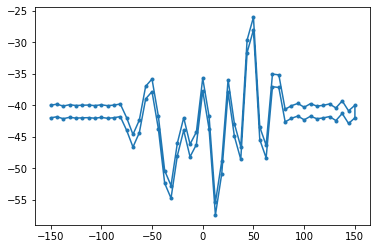

In [23]:
plt.plot(x_true,z_true,'.-')

#### create some noise

In [18]:
tf.random.set_seed(1234)
noise = tf.random.normal([obs_N],mean =constant64(0),stddev =sig_e,seed = 1,dtype = tf.float64)

In [19]:
D_noise = D+noise

In [20]:
def grav_calculate(x,z,x_obs=None,Number_=obs_N ,R=70,ax = None,style = None,**args):
    if ax is None:
        f,ax=plt.subplots()
    if x_obs is None:
        x_obs = np.linspace(-R,R,Number_)
    y = np.zeros(np.shape(x_obs))
    obv = np.vstack((x_obs,y)).T
    gravity = []
    for i in obv:
        gravity.append(-g(x,z,i))
    gravity = np.array(gravity)
    if style is None:
        style = '-'
    ax.set_title('gravity response at surface')
    ax.set_ylabel('g_z ($m/s^2$ )')
#     ax.set_ylim(4e-6,10e-6)
    ax.set_xlim(-70,70)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    ax.plot(x_obs,gravity,style,**args)
    return gravity

### Full Gravity response at surface

array([[1.31461279e-06],
       [1.32781729e-06],
       [1.33125425e-06],
       [1.32621248e-06],
       [1.32120719e-06],
       [1.32258190e-06],
       [1.32899483e-06],
       [1.33587868e-06],
       [1.34271934e-06],
       [1.35489104e-06],
       [1.37615845e-06],
       [1.39988099e-06],
       [1.40666230e-06],
       [1.38771032e-06],
       [1.35680272e-06]])

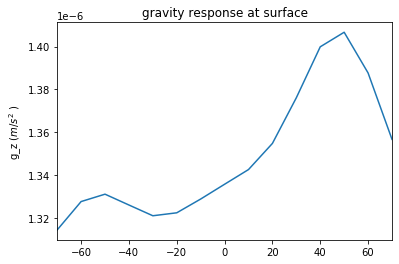

In [21]:
grav_calculate(x_true,z_true)

## Plotting function

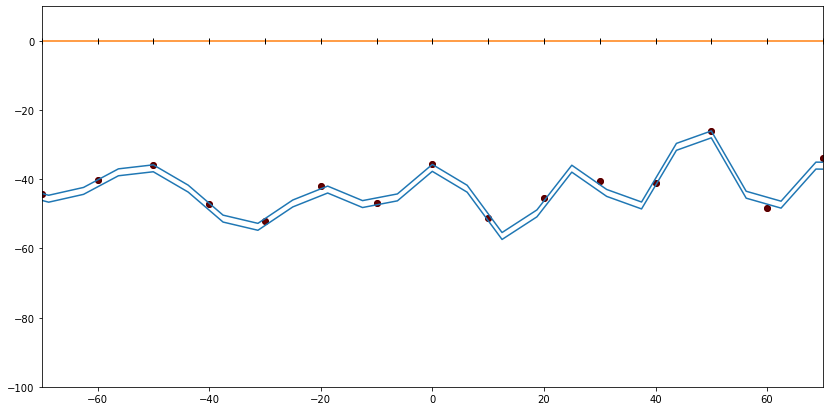

In [22]:
def Draw_inter(_control_index,_control_position,x_true = None,z_true = None,R = 70, ax = None):
    if ax is None:
        _,ax = plt.subplots(figsize = (14,7))
    if z_true is None:
        x_true,z_true = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    
    ## proposal is red
    ax.scatter(control_index,_control_position, c = 'red')
    
    ## true poistion is black
    ax.scatter(control_index,True_position, c = 'black',alpha = 0.6)
    
    ## TODO: add a labal
    ax.plot(x_true,z_true)
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N))
    ax.plot(np.linspace(-R,R,obs_N),np.zeros(obs_N),'k|')
    ax.set_ylim(-100,10)
    ax.set_xlim(-R,R)
Draw_inter(control_index,True_position)

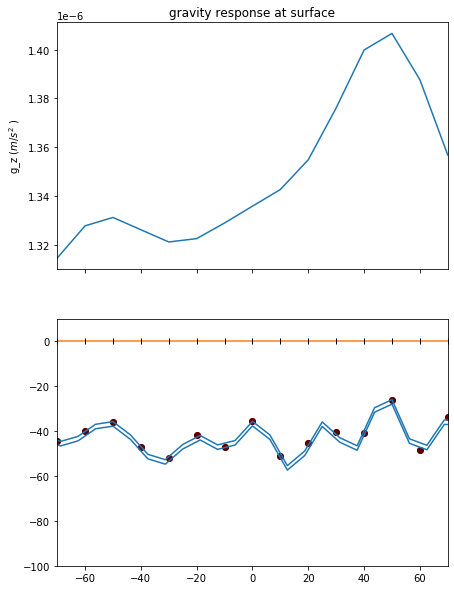

In [23]:
def Draw(_control_index,_control_position,ax = None):
    if ax is None:
        f,ax = plt.subplots(2,sharex=True, figsize = (7,10))
    _x,_z = GaussianProcess_model(kernel,observation_index_points,_control_index,_control_position)
    grav_calculate(_x,_z,ax = ax[0])
    Draw_inter(_control_index,_control_position,ax = ax[1])
Draw(control_index,True_position)

In [24]:
x_obs = np.linspace(-70,70,obs_N)

### Gravity response at receivers

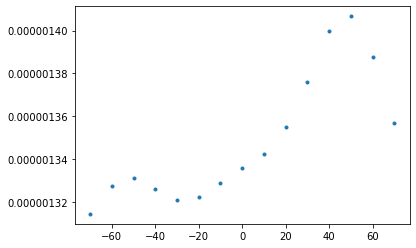

In [25]:
plt.plot(x_obs,D,'.')

#### Gradient decent

In [27]:
mu = tf.random.uniform([Number_para],minval = -50,maxval = -30,seed = 1,dtype = tf.float64) # initial parameters

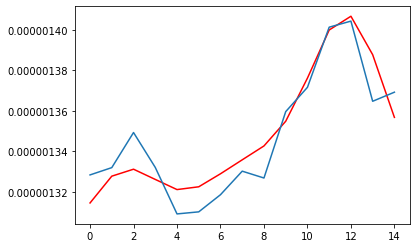

In [28]:
f,ax = plt.subplots()
ax.plot(D,'r')
ax.plot(D_noise)


In [29]:
steps_gradient_decent = 50

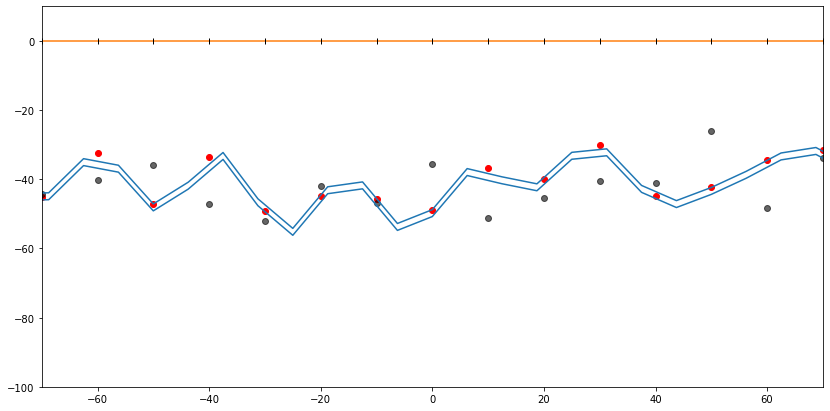

In [30]:
Draw_inter(control_index,mu)

In [31]:
steps_gradient_decent = 20

In [32]:
joint_log_post(D,mu)

<tf.Tensor: shape=(), dtype=float64, numpy=-111.51694883752594>

In [33]:
with tf.GradientTape() as t:  
    t.watch(mu)
    loss = negative_log_posterior(D,mu) # negative log posterior
    dlossdmu = t.gradient(loss,mu)
    print('loss',loss)
    print('grad',dlossdmu)

loss tf.Tensor(111.51694883752737, shape=(), dtype=float64)
grad tf.Tensor(
[1.91826064 3.77847462 2.43910517 4.20213456 2.46445333 2.99921792
 3.03666996 3.16952038 5.04931428 4.91486184 5.60628239 2.55177535
 2.18339718 2.2970123  2.70500746], shape=(15,), dtype=float64)


loss tf.Tensor(111.51694883752737, shape=(), dtype=float64)
grad tf.Tensor(
[1.91826064 3.77847462 2.43910517 4.20213456 2.46445333 2.99921792
 3.03666996 3.16952038 5.04931428 4.91486184 5.60628239 2.55177535
 2.18339718 2.2970123  2.70500746], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.25518611 -32.76345182 -47.38094212 -33.85963615 -49.31915341
 -45.17646178 -46.07167766 -49.10706546 -37.38243829 -40.51518183
 -30.62002182 -45.20807767 -42.59652254 -34.74891194 -31.74961557], shape=(15,), dtype=float64)
Iteration 0


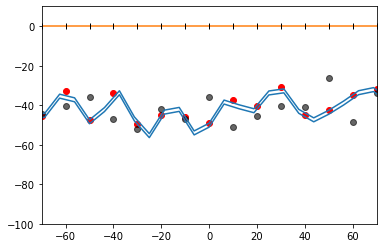

loss tf.Tensor(94.49007955124645, shape=(), dtype=float64)
grad tf.Tensor(
[1.84540257 3.57539048 2.20518487 3.85965752 2.14865334 2.6310875
 2.63285346 2.69026626 4.41406749 4.20805886 4.84297448 2.10300776
 1.84320117 2.08939268 2.62592258], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.43972637 -33.12099086 -47.6014606  -34.2456019  -49.53401875
 -45.43957053 -46.33496301 -49.37609209 -37.82384504 -40.93598772
 -31.10431927 -45.41837844 -42.78084266 -34.95785121 -32.01220783], shape=(15,), dtype=float64)
Iteration 1


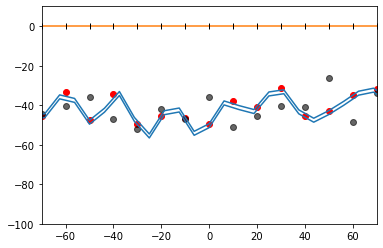

loss tf.Tensor(81.13943051352976, shape=(), dtype=float64)
grad tf.Tensor(
[1.76516814 3.37528583 1.98451352 3.54444767 1.86523932 2.31010927
 2.28527147 2.28831043 3.88799922 3.63132638 4.22141134 1.72907549
 1.55406987 1.90261111 2.54305295], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.61624318 -33.45851945 -47.79991196 -34.60004667 -49.72054268
 -45.67058146 -46.56349016 -49.60492313 -38.21264496 -41.29912036
 -31.52646041 -45.59128599 -42.93624965 -35.14811232 -32.26651312], shape=(15,), dtype=float64)
Iteration 2


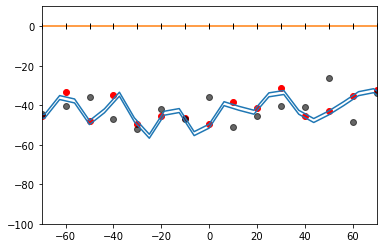

loss tf.Tensor(70.54555458199977, shape=(), dtype=float64)
grad tf.Tensor(
[1.68174646 3.18238819 1.77887638 3.2564592  1.61163438 2.02959807
 1.98488812 1.94839131 3.4476264  3.15445896 3.70806162 1.41410137
 1.30603728 1.73421934 2.45905363], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.78441783 -33.77675827 -47.97779959 -34.92569259 -49.88170612
 -45.87354127 -46.76197897 -49.79976226 -38.5574076  -41.61456625
 -31.89726657 -45.73269613 -43.06685338 -35.32153426 -32.51241849], shape=(15,), dtype=float64)
Iteration 3


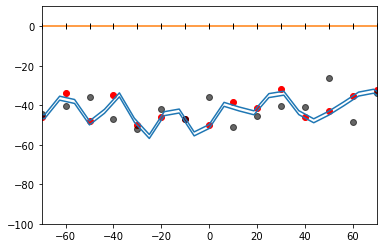

loss tf.Tensor(62.050184612527346, shape=(), dtype=float64)
grad tf.Tensor(
[1.59784105 2.99896465 1.58872331 2.99448491 1.38505718 1.78392365
 1.72440911 1.65902604 3.07574159 2.75594417 3.2792151  1.14646337
 1.09163571 1.58209873 2.37565843], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-45.94420193 -34.07665473 -48.13667193 -35.22514108 -50.02021184
 -46.05193363 -46.93441988 -49.96566487 -38.86498176 -41.89016067
 -32.22518808 -45.84734246 -43.17601695 -35.47974413 -32.74998433], shape=(15,), dtype=float64)
Iteration 4


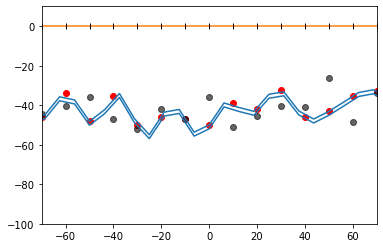

loss tf.Tensor(55.17180188671372, shape=(), dtype=float64)
grad tf.Tensor(
[1.51518986 2.82608799 1.41376001 2.75677577 1.18278025 1.56833751
 1.49788287 1.41137254 2.75940597 2.41999901 2.91758775 0.91742476
 0.90513205 1.44441629 2.29399476], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.09572092 -34.35926353 -48.27804793 -35.50081865 -50.13848986
 -46.20876738 -47.08420817 -50.10680212 -39.14092235 -42.13216057
 -32.51694685 -45.93908494 -43.26653015 -35.62418576 -32.97938381], shape=(15,), dtype=float64)
Iteration 5


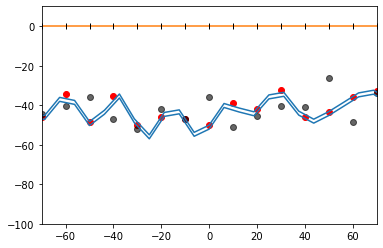

loss tf.Tensor(49.55210593563518, shape=(), dtype=float64)
grad tf.Tensor(
[1.43489321 2.66410248 1.25329151 2.54137911 1.00224893 1.37882276
 1.30040632 1.19848978 2.48867758 2.13475309 2.61025528 0.72026979
 0.74203483 1.31958272 2.214783  ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.23921024 -34.62567378 -48.40337708 -35.75495657 -50.23871475
 -46.34664966 -47.2142488  -50.2266511  -39.38979011 -42.34563588
 -32.77797238 -46.01111192 -43.34073364 -35.75614403 -33.20086211], shape=(15,), dtype=float64)
Iteration 6


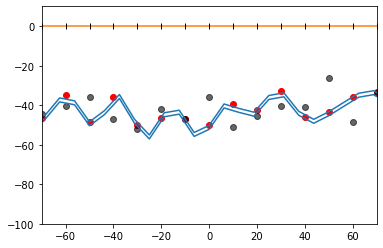

loss tf.Tensor(44.92075476379276, shape=(), dtype=float64)
grad tf.Tensor(
[1.35762536 2.51291188 1.10642386 2.34632167 0.84112871 1.21196852
 1.12790506 1.01483989 2.255776   1.89108955 2.34734314 0.54973768
 0.5987646  1.20621576 2.13846654], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.37497277 -34.87696497 -48.51401946 -35.98958873 -50.32282762
 -46.46784651 -47.32703931 -50.32813509 -39.61536771 -42.53474483
 -33.0127067  -46.06608569 -43.4006101  -35.87676561 -33.41470876], shape=(15,), dtype=float64)
Iteration 7


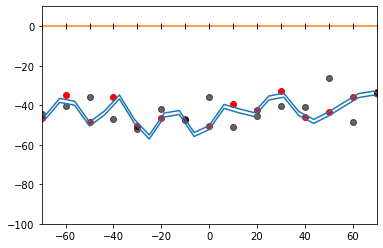

loss tf.Tensor(41.07141021663435, shape=(), dtype=float64)
grad tf.Tensor(
[1.28377369 2.37215973 0.9721828  2.16970589 0.69731592 1.06486686
 0.97696699 0.8559432  2.05451661 1.68188012 2.12116699 0.40164049
 0.47242692 1.10310925 2.06529848], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.50335014 -35.11418094 -48.61123774 -36.20655932 -50.39255922
 -46.5743332  -47.42473601 -50.41372941 -39.82081937 -42.70293285
 -33.22482339 -46.10624974 -43.44785279 -35.98707653 -33.62123861], shape=(15,), dtype=float64)
Iteration 8


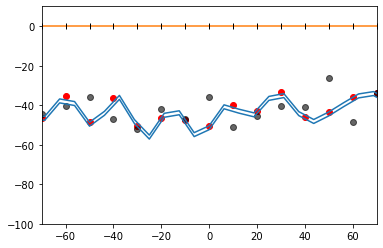

loss tf.Tensor(37.84504692367557, shape=(), dtype=float64)
grad tf.Tensor(
[1.21353176 2.24134296 0.84958293 2.00975714 0.56893011 0.93502846
 0.84471482 0.71813314 1.87991707 1.50146531 1.92565167 0.27259771
 0.36065186 1.00920705 1.99540071], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.62470332 -35.33831523 -48.69619604 -36.40753504 -50.44945223
 -46.66783604 -47.50920749 -50.48554272 -40.00881108 -42.85307938
 -33.41738856 -46.13350951 -43.48391797 -36.08799724 -33.82077868], shape=(15,), dtype=float64)
Iteration 9


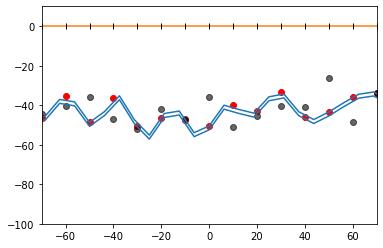

loss tf.Tensor(35.11807668955237, shape=(), dtype=float64)
grad tf.Tensor(
[1.14696218 2.11988384 0.73766724 1.86484322 0.45429807 0.82031405
 0.72870727 0.59837809 1.72791704 1.34529194 1.7559282  0.15984774
 0.26147795 0.92358143 1.92880453], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.73939954 -35.55030362 -48.76996276 -36.59401936 -50.49488204
 -46.74986745 -47.58207821 -50.54538053 -40.18160278 -42.98760857
 -33.59298138 -46.14949428 -43.51006577 -36.18035538 -34.01365913], shape=(15,), dtype=float64)
Iteration 10


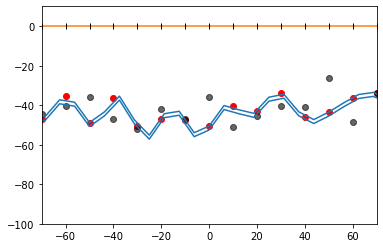

loss tf.Tensor(32.793750296780274, shape=(), dtype=float64)
grad tf.Tensor(
[1.08403973 2.00717527 0.63552847 1.73347836 0.35193455 0.71887822
 0.6268615  0.49414942 1.59517452 1.20965478 1.60804774 0.06111089
 0.17326647 0.84541485 1.86547915], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.84780351 -35.75102114 -48.83351561 -36.7673672  -50.53007549
 -46.82175527 -47.64476436 -50.59479548 -40.34112024 -43.10857405
 -33.75378616 -46.15560537 -43.52739242 -36.26489686 -34.20020705], shape=(15,), dtype=float64)
Iteration 11


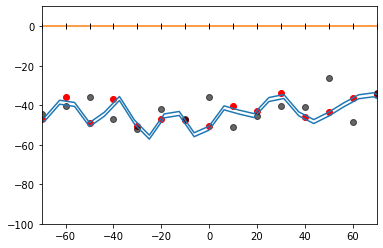

loss tf.Tensor(30.79583991765, shape=(), dtype=float64)
grad tf.Tensor(
[ 1.02468109  1.90260908  0.54231957  1.61431886  0.26052257  0.62912357
  0.53739182  0.40332203  1.47891486  1.09150849  1.47877444 -0.02551185
  0.09463709  0.77398471  1.8053517 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-46.95027162 -35.94128205 -48.88774757 -36.92879908 -50.55612775
 -46.88466763 -47.69850355 -50.63512768 -40.48901172 -43.2177249
 -33.9016636  -46.15305419 -43.53685613 -36.34229534 -34.38074222], shape=(15,), dtype=float64)
Iteration 12


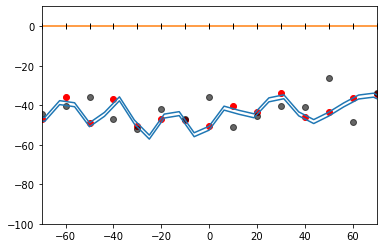

loss tf.Tensor(29.06393864719962, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.96876543  1.80559332  0.45725757  1.5061544   0.17889454  0.54966283
  0.45876051  0.32409816  1.3768172   0.98832838  1.36543258 -0.1016151
  0.02441875  0.70865056  1.74832137], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.04714816 -36.12184138 -48.93347332 -37.07941452 -50.5740172
 -46.93963391 -47.7443796  -50.66753749 -40.62669344 -43.31655774
 -34.03820686 -46.14289268 -43.539298   -36.41316039 -34.55557435], shape=(15,), dtype=float64)
Iteration 13


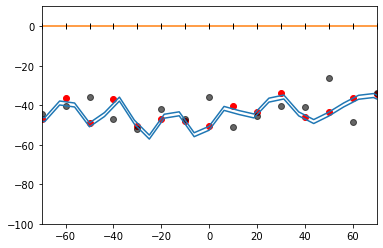

loss tf.Tensor(27.54992530938864, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.9161488   1.71556235  0.37962349  1.40789745  0.10601497  0.47928765
  0.3896383   0.25494825  1.28692752  0.89800549  1.26579204 -0.1685473
 -0.03838847  0.64884318  1.69426962], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.13876304 -36.29339762 -48.97143567 -37.22020427 -50.5846187
 -46.98756268 -47.78334343 -50.69303232 -40.75538619 -43.40635828
 -34.16478606 -46.12603795 -43.53545915 -36.47804471 -34.72500131], shape=(15,), dtype=float64)
Iteration 14


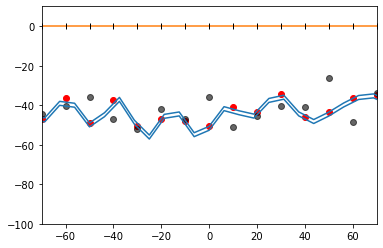

loss tf.Tensor(26.21528064709605, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.86667418  1.63198237  0.30876006  1.31857213  0.04096479  0.41694268
  0.32887205  0.19456442  1.20759136  0.81876651  1.17798101 -0.2274558
 -0.09464317  0.59405534  1.6430673 ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.22543046 -36.45659586 -49.00231168 -37.35206148 -50.58871518
 -47.02925694 -47.81623063 -50.71248876 -40.87614533 -43.48823494
 -34.28258416 -46.10329237 -43.52599484 -36.53745024 -34.88930804], shape=(15,), dtype=float64)
Iteration 15


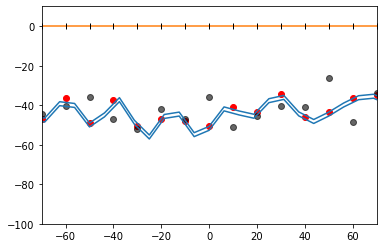

loss tf.Tensor(25.029033086499226, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.82017844  1.55435392  0.24406814  1.2373033  -0.01707248  0.36170386
  0.2754584   0.1418235   1.13740094  0.74911171  1.1004188  -0.27932229
 -0.14508638  0.54383397  1.59457987], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.3074483  -36.61203125 -49.02671849 -37.47579181 -50.58700793
 -47.06542733 -47.84377647 -50.72667111 -40.98988542 -43.56314611
 -34.39262604 -46.07536014 -43.5114862  -36.59183364 -35.04876603], shape=(15,), dtype=float64)
Iteration 16


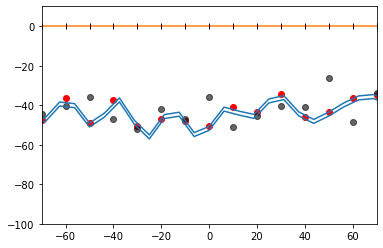

loss tf.Tensor(23.966174954774203, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.77649719  1.48221248  0.18500263  1.16330628 -0.06882297  0.31276026
  0.22852189  0.09575725  1.07515325  0.68776627  1.03176324 -0.32499081
 -0.19036061  0.49777338  1.548671  ], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.38509802 -36.7602525  -49.04521875 -37.59212244 -50.58012563
 -47.09670336 -47.86662866 -50.73624684 -41.09740075 -43.63192273
 -34.49580237 -46.04286106 -43.49245014 -36.64161098 -35.20363313], shape=(15,), dtype=float64)
Iteration 17


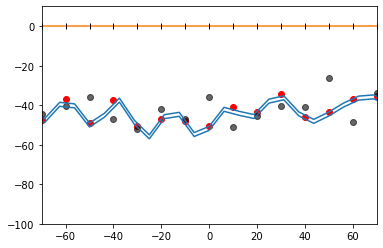

loss tf.Tensor(23.006433497031168, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.73546809  1.41512786  0.13106816  1.09587732 -0.1149332   0.26939883
  0.18729679  0.05552825  1.01981638  0.63364175  0.97086917 -0.36519031
 -0.23102522  0.45550951  1.50520517], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.45864483 -36.90176528 -49.05832557 -37.70171017 -50.56863231
 -47.12364324 -47.88535834 -50.74179966 -41.19938239 -43.69528691
 -34.59288928 -46.00634202 -43.46934762 -36.68716193 -35.35415365], shape=(15,), dtype=float64)
Iteration 18


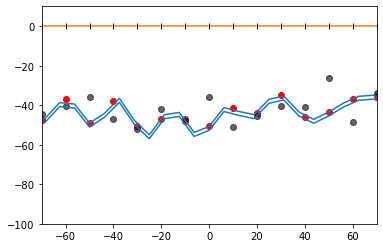

loss tf.Tensor(22.133311670971892, shape=(), dtype=float64)
grad tf.Tensor(
[ 0.69693309  1.35270286  0.08181485  1.03438496 -0.15597949  0.23099134
  0.15111195  0.02041011  0.97050231  0.58580516  0.91675538 -0.40055279
 -0.26756909  0.4167149   1.46404948], shape=(15,), dtype=float64)
mu: tf.Tensor(
[-47.52833814 -37.03703557 -49.06650705 -37.80514867 -50.55303436
 -47.14674237 -47.90046954 -50.74384067 -41.29643262 -43.75386742
 -34.68456482 -45.96628675 -43.44259071 -36.72883342 -35.5005586 ], shape=(15,), dtype=float64)
Iteration 19


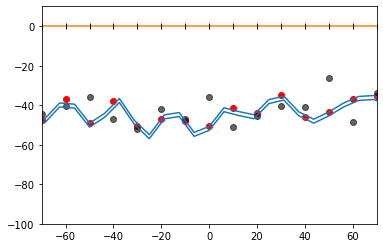

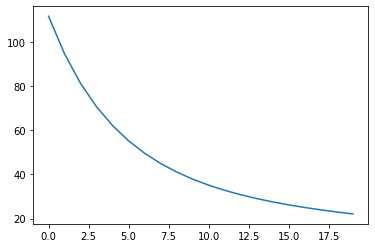

In [34]:
lost = []
for i in range(steps_gradient_decent):
    with tf.GradientTape() as t:  
        t.watch(mu)
        loss = negative_log_posterior(D,mu) # negative log posterior
        lost.append(loss.numpy())
        dlossdmu = t.gradient(loss,mu)
        print('loss',loss)
        print('grad',dlossdmu)
    mu = mu-tf.multiply(constant64(0.1),dlossdmu)
    print('mu:',mu)
    f,ax = plt.subplots()
    Draw_inter(control_index,mu,ax = ax)
    print('Iteration',i)
    plt.show()
plt.plot(lost)

## TODO: use Draw() instead of Draw_inter()

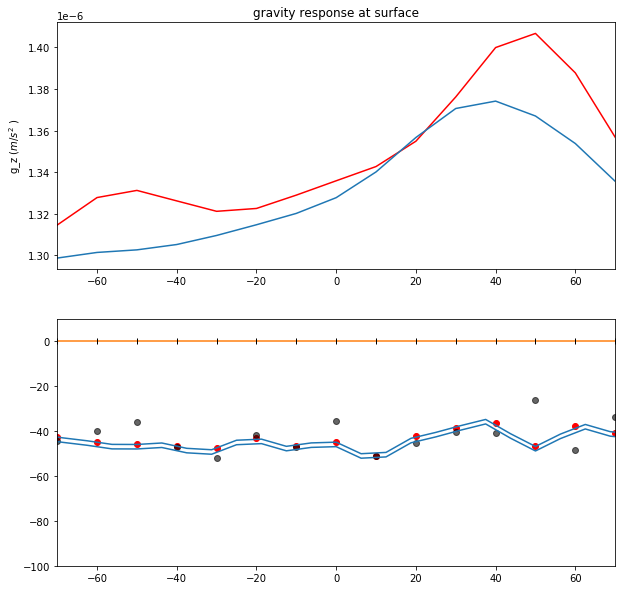

In [54]:
f,ax = plt.subplots(2,figsize =(10,10))
ax[0].plot(x_obs,D,'r')
Draw(control_index,mu,ax)

In [35]:
MAP = mu

In [69]:
negative_log_posterior(D,mu)

<tf.Tensor: shape=(), dtype=float64, numpy=10.079126656205545>

### Random Walk MCMC

In [60]:
# num_results = number_sample
# burnin = number_burnin

num_results=20
burnin = 0

initial_chain_state = [
    -50 * tf.ones([Number_para], dtype=tf.float64, name="init_t1"),
]

unnormalized_posterior_log_prob = lambda *args: joint_log_post(D,*args)

def gauss_new_state_fn(scale, dtype):
  gauss = tfd.Normal(loc=dtype(0), scale=dtype(scale))
  def _fn(state_parts, seed):
    next_state_parts = []
    seed_stream  = tfp.util.SeedStream(seed, salt='RandomNormal')
    for sp in state_parts:
      next_state_parts.append(sp + gauss.sample(
        sample_shape=sp.shape, seed=seed_stream()))
    return next_state_parts
  return _fn

dtype = np.float64

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=initial_chain_state,
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        new_state_fn=gauss_new_state_fn(scale=1, dtype=dtype)),
    num_burnin_steps=burnin,
    num_steps_between_results=1,  # Thinning.
    parallel_iterations=1)

samples = tf.stack(samples, axis=-1)
accepted = kernel_results.is_accepted

samples = samples.numpy()
accepted = accepted.numpy()

/Users/zhouji/anaconda3/envs/bys/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [70]:
print('previous is 2m 39s for 20 iteration, now is 10.6s. It is %.1f times faster' %((2*60+39)/10.6))

previous is 2m 39s for 20 iteration, now is 10.6s. It is 15.0 times faster


In [61]:
samples

array([[[-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ],
        [-50.        ]],

       [[-50.09785702],
        [-48.60347202],
        [-47.31912121],
        [-49.73470373],
        [-50.55080298],
        [-48.68155202],
        [-49.2783426 ],
        [-50.81322545],
        [-50.7411252 ],
        [-52.96426688],
        [-47.39261331],
        [-47.86029267],
        [-49.51032964],
        [-50.42441438],
        [-50.08568295]],

       [[-50.7220873 ],
        [-50.06257731],
        [-46.25435773],
        [-49.4368523 ],
        [-50.88943897],
        [-47.9992138 ],
        [-48.96753636],
        [-49.69422697],
        [-50.61220951],
        [-54.6032529 ],
        [-47.95194456],
        [-46

In [ ]:
accept_index = np.where(accepted==True)
accepted_samples = samples[accept_index]

In [ ]:
print('Acceptance rate = %0.1f%%' % (100*accepted_samples.shape[0]/num_results))

In [ ]:
#TODO
def draw_MCMC(samples,Truth = None,ax = None,R = 70):
    
    if ax == None:
        f,ax=plt.subplots(figsize = (10,5))
    
#     if Truth is not None:
#         draw(base,Truth,ax = ax, R = R)
            
    x_cor = tf.linspace(constant64(-70),constant64(70),Number_para)
    
    for ps in samples:
        ax.plot(x_cor,ps,'r.',alpha =0.2)
        ps = tf.reshape(ps,[ps.shape[0]])
        GaussianProcess_model_plot(control_index,ps,ax = ax, alpha = 0.2)
    ax.set_ylim(-70,0)
    ax.set_xlim(-R,R)

In [ ]:
draw_MCMC(samples) # [:,:,0] transpost the results for plotting

In [ ]:
corner.corner(accepted_samples[:,:,0])

# Hessian Method

### First derivative is working properly 

In [73]:
with tf.GradientTape() as tt:
    tt.watch(MAP)
    loss = negative_log_posterior(D,MAP)
jac = tt.gradient(loss,MAP,unconnected_gradients='zero')

jac

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([ 0.42213789, -0.15418095, -0.41969847, -0.28375062, -0.08508132,
        0.71838212,  0.67547822,  1.02951777,  0.30344437,  1.06161138,
        0.73237112,  0.02522932, -1.08147523, -0.51712177, -0.14713005])>

In [18]:
import tensorflow as tf

x = tf.constant([1.,2.,3.,4.])

def theta(x, p):
    if tf.math.not_equal(x[p], tf.constant(0.)) :
        return(x[p]*tf.constant([1.]))
    else: return tf.constant([0.])

@tf.function
def g(x):

    Z_sum = tf.constant([0.])

    for i in tf.range(6):
        Z_sum = tf.add(Z_sum, theta(x,0))

    return(Z_sum)


with tf.GradientTape() as tt:
    tt.watch(x)
    loss = g(x)
jac = tt.gradient(loss,x)
print(jac)

with tf.GradientTape() as t:
    t.watch(x)
    with tf.GradientTape() as tt:
        tt.watch(x)
        loss = g(x)
    jac = tt.gradient(loss,x,unconnected_gradients = 'zero')
hess = t.gradient(jac,x)
print(hess)

tf.Tensor([6. 0. 0. 0.], shape=(4,), dtype=float32)


ValueError: Tried to convert 'tensor' to a tensor and failed. Error: None values not supported.

In [28]:
z_true

<tf.Tensor: shape=(98, 1), dtype=float64, numpy=
array([[-41.99999992],
       [-41.83104026],
       [-42.13361926],
       [-41.91473461],
       [-42.04148257],
       [-41.99677956],
       [-41.97032897],
       [-42.05607539],
       [-41.92758539],
       [-42.0694752 ],
       [-41.98027155],
       [-41.8036255 ],
       [-43.97973252],
       [-46.63262257],
       [-44.36606441],
       [-38.99553485],
       [-37.8347287 ],
       [-43.71063731],
       [-52.37626876],
       [-54.75212587],
       [-48.00113914],
       [-43.98319755],
       [-48.17737023],
       [-46.24401254],
       [-37.71510554],
       [-43.74542858],
       [-57.40550913],
       [-50.86566871],
       [-37.94500954],
       [-44.95300216],
       [-48.58252292],
       [-31.63827916],
       [-28.03504996],
       [-45.47145934],
       [-48.34580217],
       [-37.05454307],
       [-37.18166063],
       [-42.63614753],
       [-42.07424192],
       [-41.71364559],
       [-42.31711045],
       [

### However the second derivative is still broken

In [153]:
with tf.GradientTape() as t:
    t.watch(z_true)
    with tf.GradientTape() as tt:
        tt.watch(z_true)
        loss = g(x_true,z_true)
    jac = tt.gradient(loss,z_true)
hess = t.gradient(jac,z_true)

In [154]:
hess

<tf.Tensor: shape=(98, 1), dtype=float64, numpy=
array([[ 0.00000000e+00],
       [-6.19525625e-10],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.0000

In [ ]:
def Full_Hessian():
    Hess = tf.TensorArray(tf.float64, size=Number_para)
    j=0
    for i in range(Number_para):
        print(j)
        with tf.GradientTape() as t:
            t.watch(MAP)
            with tf.GradientTape() as tt:
                tt.watch(MAP)
                loss = negative_log_posterior(D,MAP)
            jac = tt.gradient(loss,MAP,unconnected_gradients='zero')[i]
        hess = t.gradient(jac,MAP,unconnected_gradients = 'none')
        Hess = Hess.write(j,hess)
        j = j+1
    return Hess.stack()

New_Hessian = Full_Hessian()

In [ ]:
plt.imshow(New_Hessian)

In [ ]:
def Laplace_appro(H,C_prior):
    return tf.linalg.inv((tf.add(H,tf.linalg.inv(C_prior))))


In [ ]:
cov_post = Laplace_appro(New_Hessian,cov_prior)

In [ ]:
@tf.function
def matrixcompute(matrix1,matrix2,Cov):
    matrix1 = tf.cast(matrix1,tf.float64)
    matrix2 = tf.cast(matrix2,tf.float64)
    matrix = tf.subtract(matrix1, matrix2)
    matrix = tf.reshape(matrix,[matrix.shape[0],1])
    matrix_T = tf.transpose(matrix)
    Cov_inv = tf.linalg.inv(Cov)
    result = tf.multiply(constant64(1/2),tf.matmul(tf.matmul(matrix_T,Cov_inv),matrix))
    return result

def acceptance_gpCN(m_current , m_proposed):
    delta_current = tf.add(negative_log_posterior(D,m_current),matrixcompute(m_current,MAP,cov_post))
    delta_proposed = tf.add(negative_log_posterior(D,m_proposed),matrixcompute(m_proposed,MAP,cov_post))

    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False
        
from IPython.display import clear_output
# define leaning rate
beta = constant64(0.9)

@tf.function
def draw_proposal(m_current):
    
    _term1 = MAP
    
    ## sqrt term
    tem_1 = tf.convert_to_tensor(tf.sqrt(1-beta**2),dtype = tf.float64)
    ## sqrt(1-beta^2)()
    _term2 = tf.multiply(tem_1,(tf.subtract(m_current,MAP)))
    
    
    Xi = tfd.MultivariateNormalTriL(loc=0, scale_tril=tf.linalg.cholesky(cov_post))
    
#     Xi = tfd.MultivariateNormalFullCovariance(
#             loc = 0,
#             covariance_matrix= cov_post)

    Xi_s = tfd.Sample(Xi)
    _term3 = tf.multiply(beta,Xi_s.sample())
    
    m_proposed = tf.add(MAP,tf.add(_term2,_term3))
    
    return m_proposed       

In [ ]:
mu_init = -50 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        
        if acceptance_gpCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_gpCN = np.array(accepted)



In [ ]:
draw_MCMC(accepted_gpCN)

### try pCN MCMC

first define a likelihood function rather than posteior function

In [ ]:
def log_likelihood(D,_control_position):
    """
    D: is the observation data
    ps: Positions,Variable(N elements vector)
    """
    # define random variables prior
    
    _control_index = tf.linspace(constant64(-70),constant64(70),Number_para)
    __x,__z = GaussianProcess_model(_control_index,_control_position)
    
    Gm_ = grav(__x,__z)
    
    mvn_likelihood = tfd.MultivariateNormalTriL(
            loc = Gm_,
            scale_tril= tf.linalg.cholesky(cov))
    
    # return the posterior probability
    return (mvn_likelihood.log_prob(D))

def negative_likeli(_control_position):
    return tf.negative(log_likelihood(D,_control_position))

In [ ]:
def acceptance_pCN(m_current , m_proposed):
    delta_current = negative_likeli(m_current)
    delta_proposed = negative_likeli(m_proposed)
    ## calculate accept ratio if exp()<1
    accept_ratio = tf.exp(tf.subtract(delta_current,delta_proposed))
    acceptsample = tfd.Sample(
    tfd.Uniform(constant64(0), constant64(1)),
    sample_shape=[1,1])
    sample = acceptsample.sample()
    
    if(accept_ratio > sample):
        return True
    else:
        return False

In [ ]:
mu_init = -50 * tf.ones([Number_para], dtype=tf.float64)

number_of_steps = number_sample
def run_chain():
    burn_in = number_burnin
    steps = number_of_steps
    k = 0
    accepted = []
    rejected = []

    m_current = mu_init  # init m
    
    for k in range(steps+burn_in):

        m_proposed = draw_proposal(m_current)

        if acceptance_pCN(m_current,m_proposed):
            m_current = m_proposed
            if k > burn_in:
                accepted.append(m_proposed.numpy())
        else:
            m_current = m_current
            rejected.append(m_proposed.numpy())
    
    return accepted,rejected
#     print("acceptance rate = %0.1f%%", 100*np.shape(accepted)[0]/steps)
    
accepted,rejected = run_chain()
np.shape(accepted)[0]
print('Acceptance rate = %0.1f%%' % (100*np.shape(accepted)[0]/number_of_steps))

accepted_pCN = np.array(accepted)

In [ ]:
draw_MCMC(accepted_pCN)

In [ ]:
corner.corner(accepted_pCN)

In [ ]:
print('run success')